In [1]:
import numpy as np     #只需要下载numpy库即可
import random
import GridWorld_v3
from draw import draw  #绘图函数
from ExperienceReplayBuffer import ExperienceReplayBuffer
import tqdm

In [2]:
rows = 5      #记得行数和列数这里要同步改
columns = 5
gridworld = GridWorld_v3.GridWorld_v3(forbiddenAreaScore=-10, score=1,desc = [".....",".##..","..#..",".#T#.",".#..."]) 
gridworld.show()
trajectorySteps = 1000

⬜️⬜️⬜️⬜️⬜️
⬜️🚫🚫⬜️⬜️
⬜️⬜️🚫⬜️⬜️
⬜️🚫✅🚫⬜️
⬜️🚫⬜️⬜️⬜️


In [3]:
state_values = np.array([random.random() for i in range(25)])
learning_rate = 0.01
gamma = 0.99

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.fc1 = nn.Linear(2,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,5)  #拟合的Action value，5个输出
    def forward(self, state):
        h1 = self.fc1(state)
        h1 = F.relu(h1)
        h2 = self.fc2(h1)
        h2 = F.relu(h2)
        Q = self.fc3(h2)
        return Q
        

In [5]:
experiencePool = ExperienceReplayBuffer(max_size=10000)
policy = 0.2 * np.ones((rows*columns,5))
episodes = [gridworld.getTrajectoryScore(nowState = 10,action = random.randint(0,4),policy = policy) 
            for i in range(500)]
for trajectory in episodes:
    for exp in trajectory:
        experiencePool.add_expericence(exp)

In [6]:
lr = 0.0015
network = model()
optimizer = optim.Adam(network.parameters(), lr = lr)
batch_size = 100

In [9]:
batch_size = 10
batch = experiencePool.sample_batch(batch_size=batch_size)
tmpstate, tmpaction, tmpscore, nextState, nextAction, terminal = batch

tmpstate = tmpstate.reshape(batch_size,1)
tmpstate = np.hstack((tmpstate // 5, tmpstate % 5))  #将state变成了行列
nextState = nextState.reshape(batch_size,1)
nextState = np.hstack((nextState // 5, nextState % 5))  #将state变成了行列

tmpstate = torch.tensor(tmpstate,dtype = torch.float32).view(batch_size,2)
nextState = torch.tensor(nextState,dtype = torch.float32).view(batch_size,2)

# tmpaction = torch.tensor(tmpaction,dtype = torch.int).view(batch_size,1)
# nextAction = torch.tensor(nextAction,dtype = torch.int).view(batch_size,1)

tmpscore = torch.tensor(tmpscore,dtype = torch.float32).view(batch_size,1)
terminal = torch.tensor(terminal,dtype = torch.float32).view(batch_size,1)

In [10]:
# 以下一个state出发，计算下一个state的五个action values
next_action_values = network(nextState)  #网络

b = [next_action_values[i,nextAction[i]] for i in range(batch_size)]
next_action_value = torch.tensor(b,dtype = torch.float32).view(batch_size,1)

# c = next_action_values.max(1)[0] #改成DQN了，这里就得取最大值
# next_action_value = torch.tensor(c,dtype = torch.float32).view(batch_size,1)

target = tmpscore + (1.0 - terminal) * gamma * next_action_value

In [11]:
next_action_values

tensor([[ -96.2449,  -92.9071, -106.2376,  -97.6344,  -95.4992],
        [ -94.5378,  -80.1261,  -97.9258,  -97.8510,  -92.7144],
        [ -96.9327, -100.3035,  -98.1051,  -95.7922,  -94.9901],
        [ -82.9245,  -75.3085,  -77.9110,  -80.1335,  -76.3360],
        [ -93.1466,  -80.9654,  -79.8119,  -84.3040,  -82.3668],
        [ -59.4939,  -46.0709,  -37.8140,  -55.2562,  -58.1418],
        [ -96.2449,  -92.9071, -106.2376,  -97.6344,  -95.4992],
        [-100.5213,  -66.3706,  -69.6853,  -84.5793,  -86.8407],
        [ -76.3359,  -75.7966,  -67.1142,  -78.4625,  -72.3573],
        [ -82.9245,  -75.3085,  -77.9110,  -80.1335,  -76.3360]],
       grad_fn=<AddmmBackward0>)

In [12]:
b

[tensor(-92.9071, grad_fn=<SelectBackward0>),
 tensor(-97.8510, grad_fn=<SelectBackward0>),
 tensor(-100.3035, grad_fn=<SelectBackward0>),
 tensor(-76.3360, grad_fn=<SelectBackward0>),
 tensor(-82.3668, grad_fn=<SelectBackward0>),
 tensor(-55.2562, grad_fn=<SelectBackward0>),
 tensor(-96.2449, grad_fn=<SelectBackward0>),
 tensor(-66.3706, grad_fn=<SelectBackward0>),
 tensor(-67.1142, grad_fn=<SelectBackward0>),
 tensor(-77.9110, grad_fn=<SelectBackward0>)]

In [13]:
next_action_value

tensor([[ -92.9071],
        [ -97.8510],
        [-100.3035],
        [ -76.3360],
        [ -82.3668],
        [ -55.2562],
        [ -96.2449],
        [ -66.3706],
        [ -67.1142],
        [ -77.9110]])

In [14]:
now_action_values = network(tmpstate)    #网络

now_action_value = now_action_values[0,tmpaction[0]]

for i in range(1,batch_size):
    now_action_value = torch.cat((now_action_value.view(-1), now_action_values[i,tmpaction[i]].view(-1)),dim=0)

now_action_value = now_action_value.view(-1,1)

In [17]:
tmpaction

array([4, 1, 0, 2, 4, 2, 4, 0, 1, 4])

In [16]:
now_action_values

tensor([[ -96.2449,  -92.9071, -106.2376,  -97.6344,  -95.4992],
        [ -96.2449,  -92.9071, -106.2376,  -97.6344,  -95.4992],
        [ -99.1212, -103.9401,  -82.6382,  -94.2308,  -95.5761],
        [ -93.1466,  -80.9654,  -79.8119,  -84.3040,  -82.3668],
        [ -93.1466,  -80.9654,  -79.8119,  -84.3040,  -82.3668],
        [ -94.2519,  -74.0517,  -21.8290,  -71.2082,  -79.8564],
        [ -96.2449,  -92.9071, -106.2376,  -97.6344,  -95.4992],
        [ -79.6019,  -23.4018,  -75.4142,  -79.4288,  -70.3472],
        [ -82.4260,  -75.7071,  -62.7962,  -95.2689,  -81.6668],
        [ -82.9245,  -75.3085,  -77.9110,  -80.1335,  -76.3360]],
       grad_fn=<AddmmBackward0>)

In [15]:
now_action_value

tensor([[-95.4992],
        [-92.9071],
        [-99.1212],
        [-79.8119],
        [-82.3668],
        [-21.8290],
        [-95.4992],
        [-79.6019],
        [-75.7071],
        [-76.3360]], grad_fn=<ViewBackward0>)

  0%|                                                                              | 0/5000 [00:00<?, ?it/s]

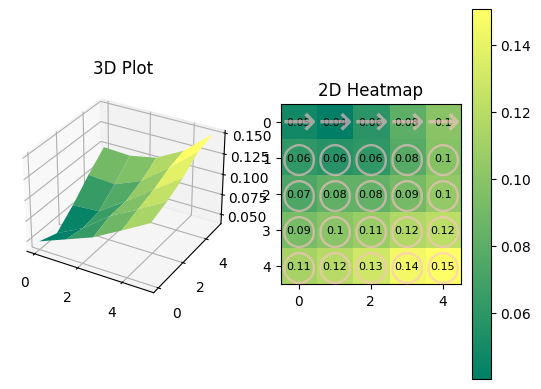

  2%|█▎                                                                  | 97/5000 [00:01<00:48, 101.36it/s]

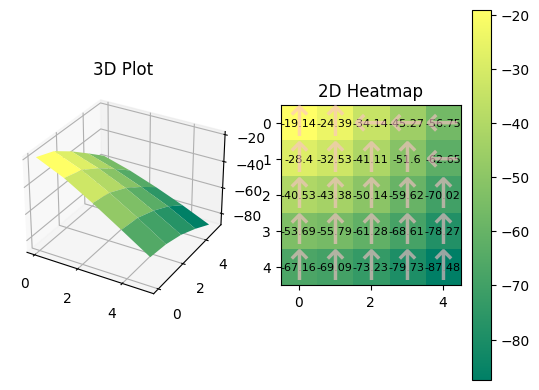

  4%|██▌                                                                | 191/5000 [00:02<00:47, 100.62it/s]

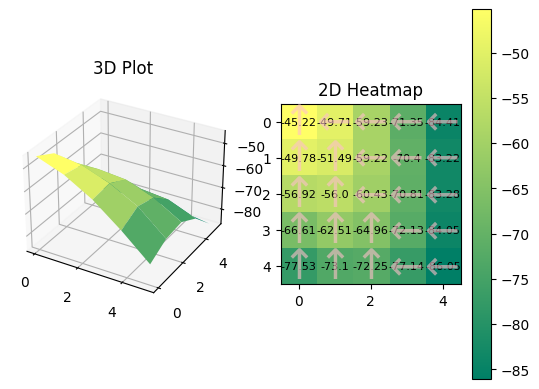

  6%|███▉                                                                | 293/5000 [00:04<00:48, 97.74it/s]

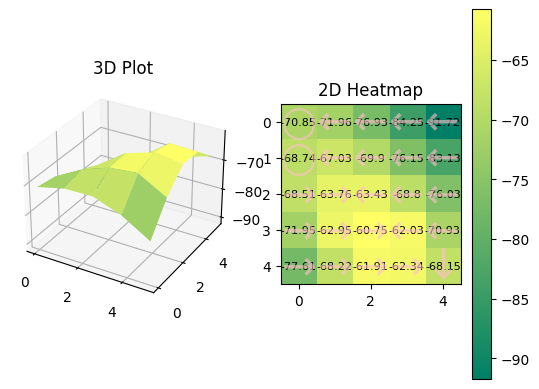

  8%|█████▎                                                              | 395/5000 [00:05<00:50, 91.90it/s]

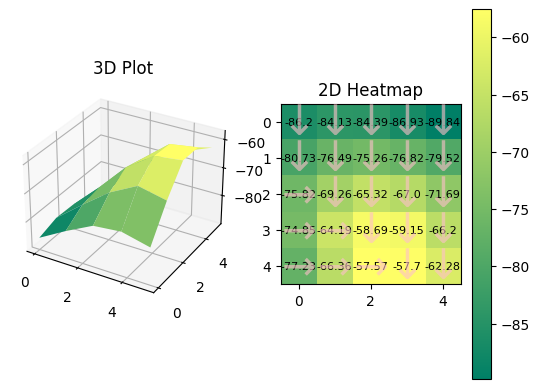

 10%|██████▋                                                            | 495/5000 [00:06<00:44, 101.99it/s]

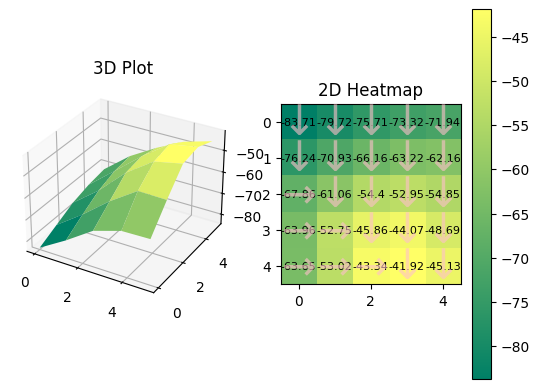

 12%|████████                                                            | 596/5000 [00:08<00:48, 91.22it/s]

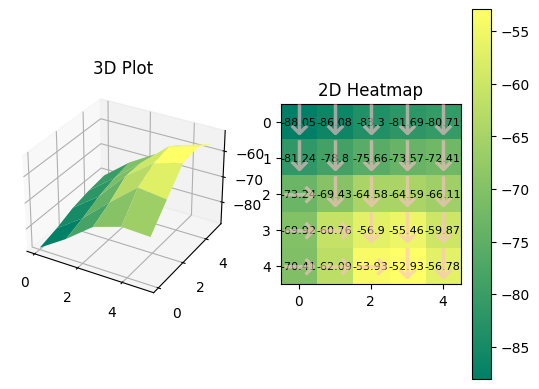

 14%|█████████▏                                                         | 690/5000 [00:09<00:43, 100.11it/s]

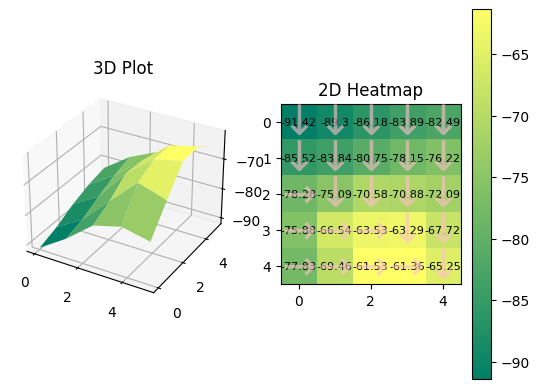

 16%|██████████▋                                                        | 797/5000 [00:10<00:40, 104.96it/s]

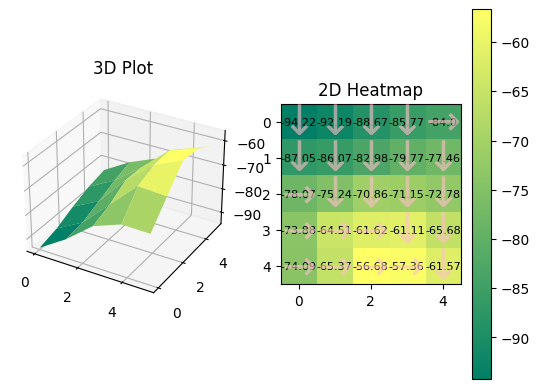

 18%|███████████▉                                                       | 892/5000 [00:12<00:40, 101.05it/s]

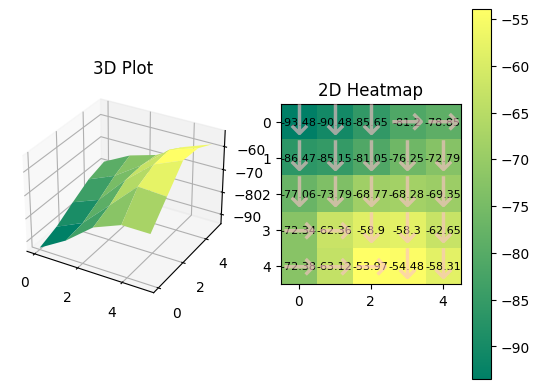

 20%|█████████████▎                                                     | 997/5000 [00:13<00:39, 100.81it/s]

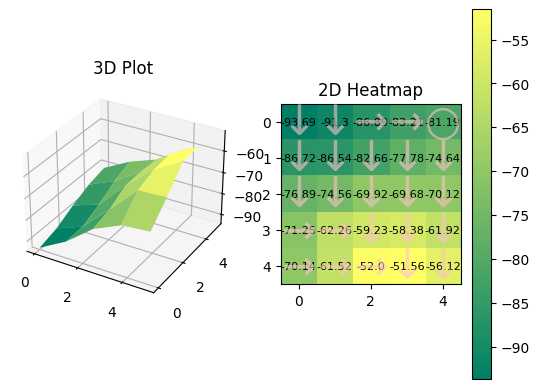

 22%|██████████████▍                                                   | 1091/5000 [00:15<00:38, 102.04it/s]

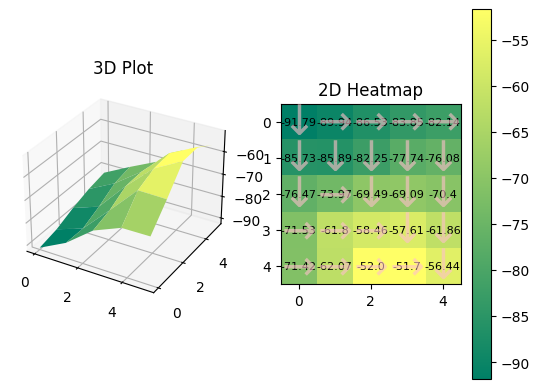

 24%|███████████████▊                                                  | 1198/5000 [00:16<00:36, 105.19it/s]

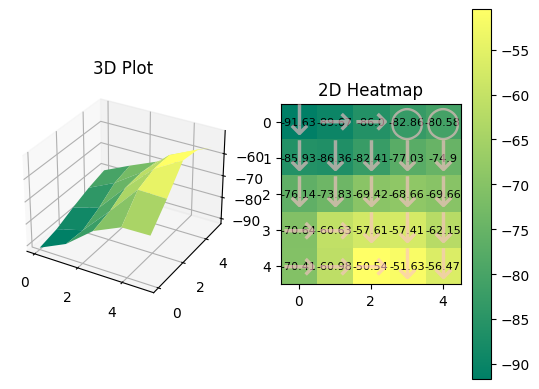

 26%|█████████████████                                                 | 1293/5000 [00:17<00:36, 102.51it/s]

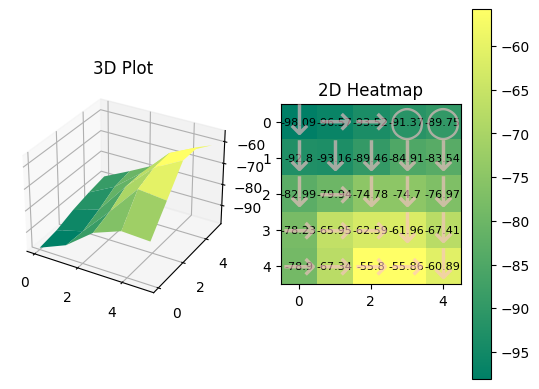

 28%|██████████████████▍                                               | 1400/5000 [00:18<00:34, 105.25it/s]

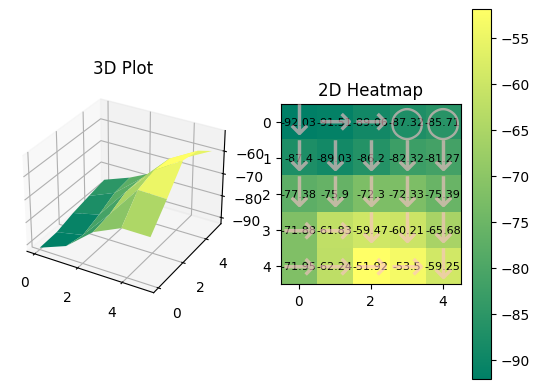

 30%|███████████████████▋                                              | 1495/5000 [00:20<00:34, 102.74it/s]

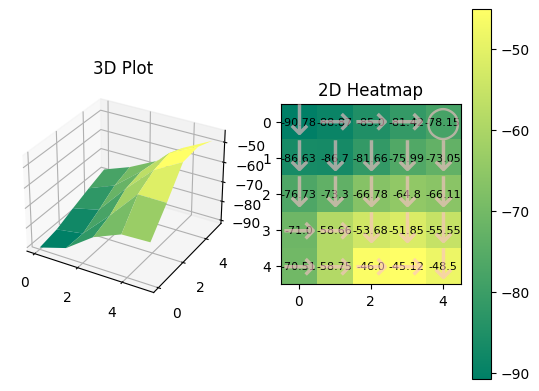

 32%|█████████████████████▎                                             | 1591/5000 [00:21<00:38, 88.03it/s]

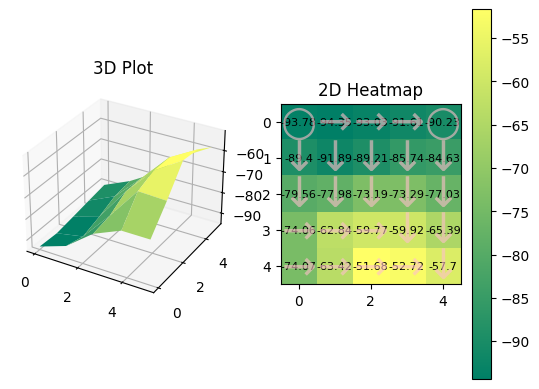

 34%|██████████████████████▍                                           | 1696/5000 [00:23<00:31, 104.17it/s]

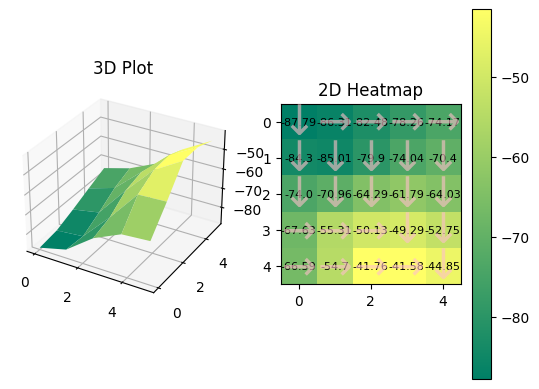

 36%|███████████████████████▉                                           | 1791/5000 [00:24<00:34, 93.16it/s]

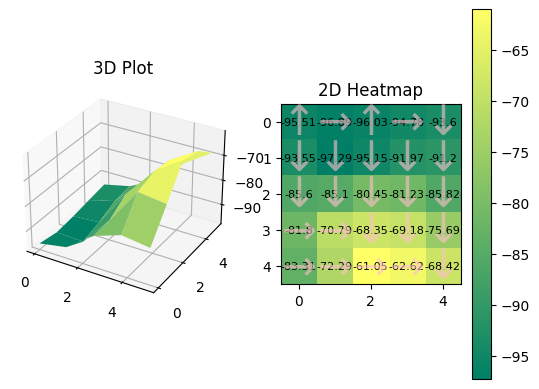

 38%|█████████████████████████▍                                         | 1897/5000 [00:26<00:45, 67.70it/s]

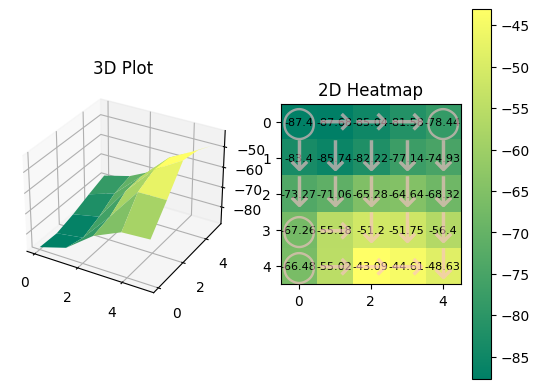

 40%|██████████████████████████▋                                        | 1995/5000 [00:28<00:44, 66.82it/s]

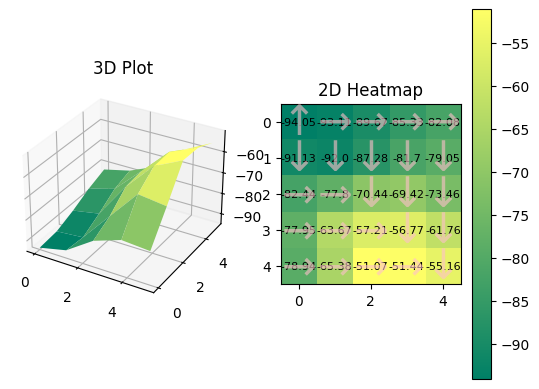

 42%|████████████████████████████                                       | 2098/5000 [00:29<00:38, 75.12it/s]

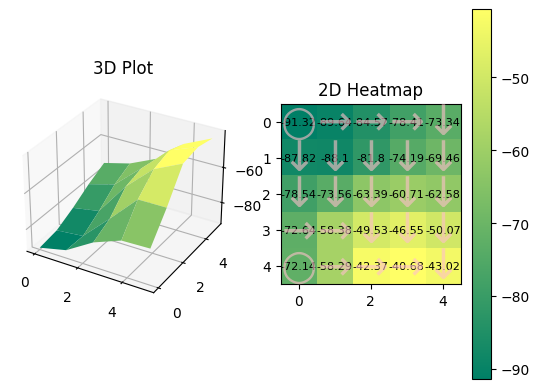

 44%|█████████████████████████████▍                                     | 2194/5000 [00:31<00:37, 74.03it/s]

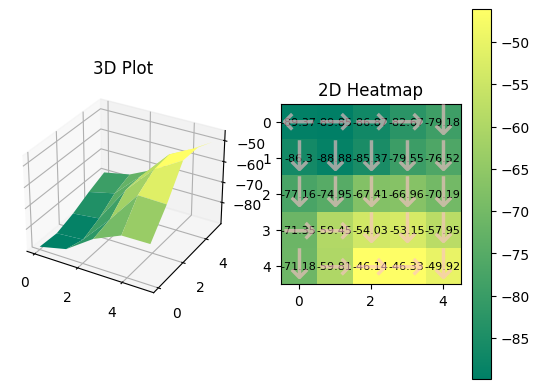

 46%|██████████████████████████████▊                                    | 2298/5000 [00:33<00:36, 74.64it/s]

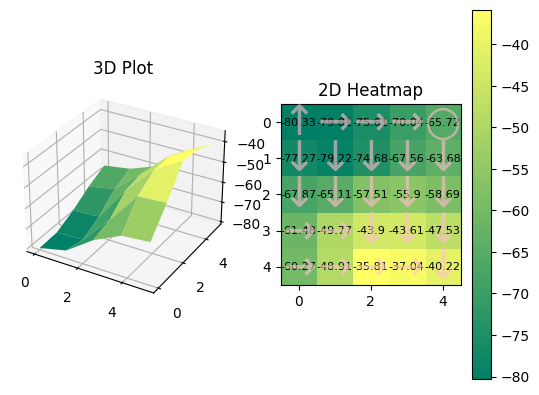

 48%|████████████████████████████████                                   | 2394/5000 [00:35<00:34, 74.53it/s]

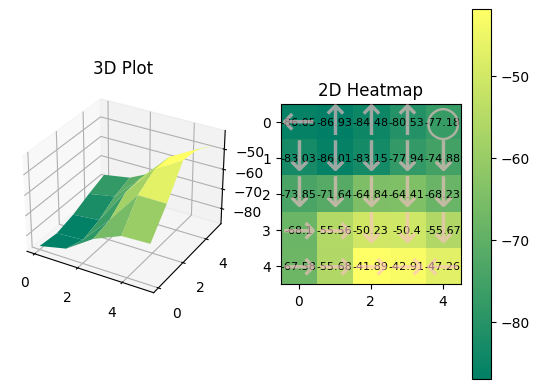

 50%|█████████████████████████████████▍                                 | 2498/5000 [00:36<00:33, 75.30it/s]

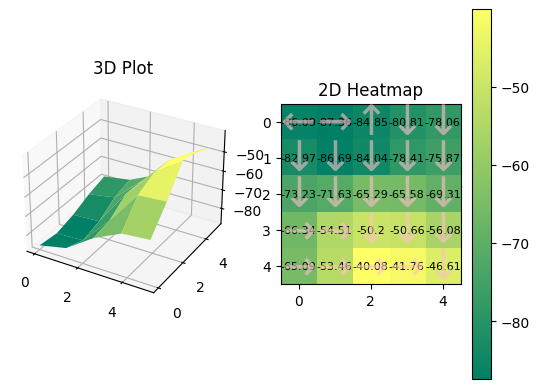

 52%|██████████████████████████████████▊                                | 2594/5000 [00:38<00:32, 74.44it/s]

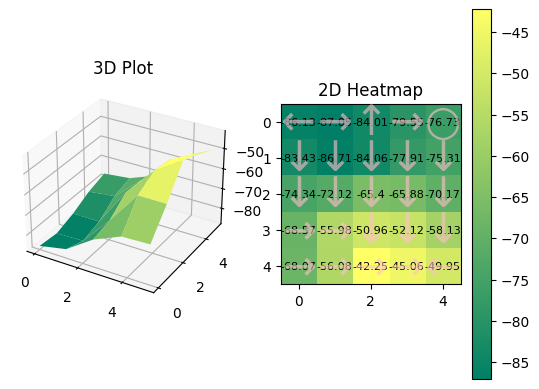

 54%|████████████████████████████████████▏                              | 2698/5000 [00:40<00:30, 75.25it/s]

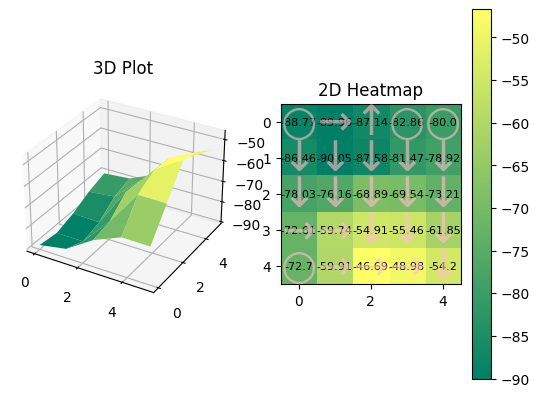

 56%|█████████████████████████████████████▍                             | 2796/5000 [00:41<00:24, 91.07it/s]

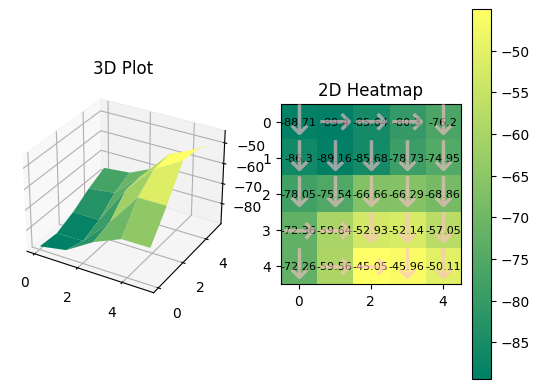

 58%|██████████████████████████████████████▊                            | 2898/5000 [00:43<00:21, 97.98it/s]

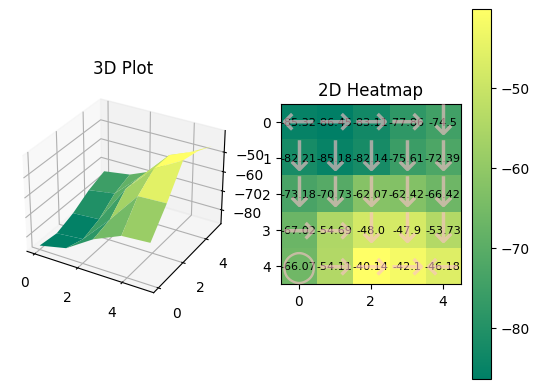

 60%|███████████████████████████████████████▌                          | 2993/5000 [00:44<00:19, 103.08it/s]

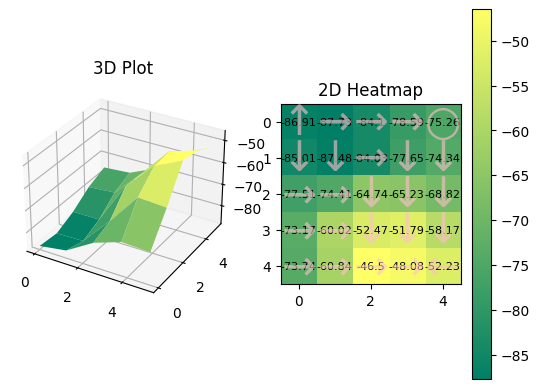

 62%|█████████████████████████████████████████▍                         | 3091/5000 [00:45<00:20, 91.81it/s]

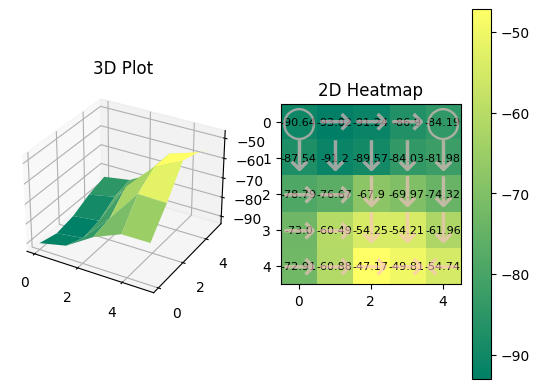

 64%|██████████████████████████████████████████▊                        | 3191/5000 [00:47<00:19, 91.82it/s]

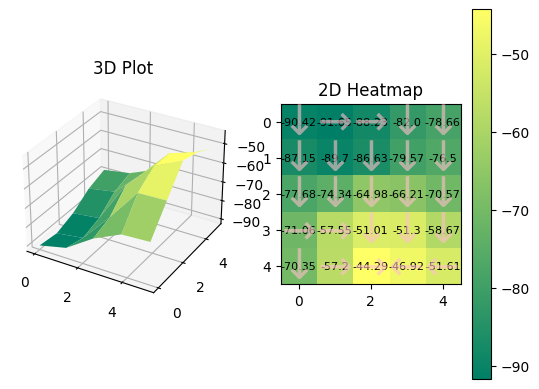

 66%|████████████████████████████████████████████                       | 3291/5000 [00:48<00:18, 91.89it/s]

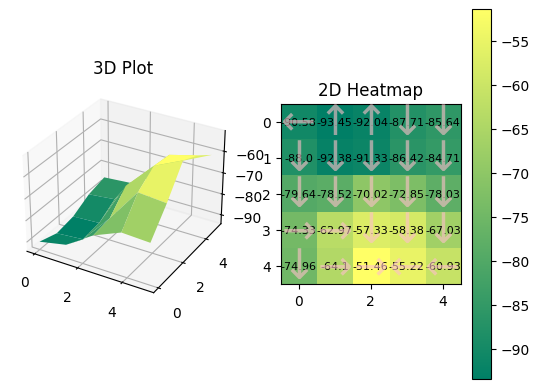

 68%|████████████████████████████████████████████▊                     | 3397/5000 [00:50<00:15, 103.44it/s]

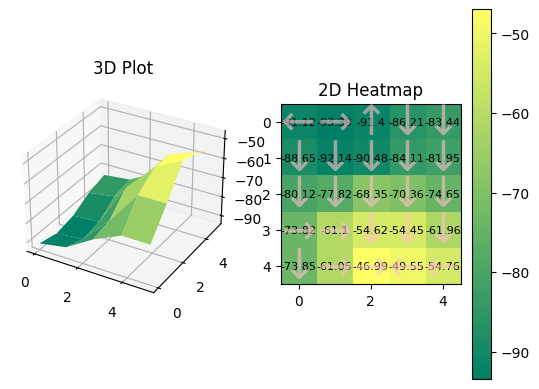

 70%|██████████████████████████████████████████████                    | 3493/5000 [00:51<00:14, 103.32it/s]

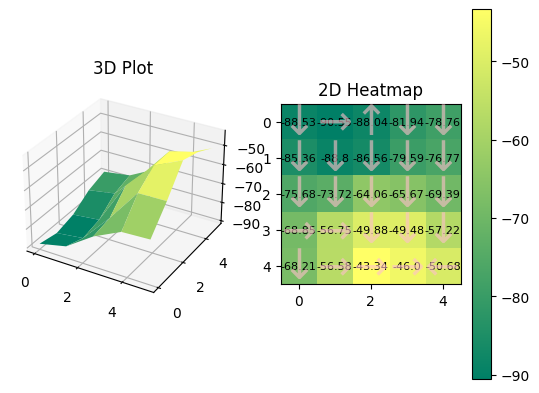

 72%|███████████████████████████████████████████████▎                  | 3589/5000 [00:52<00:13, 103.02it/s]

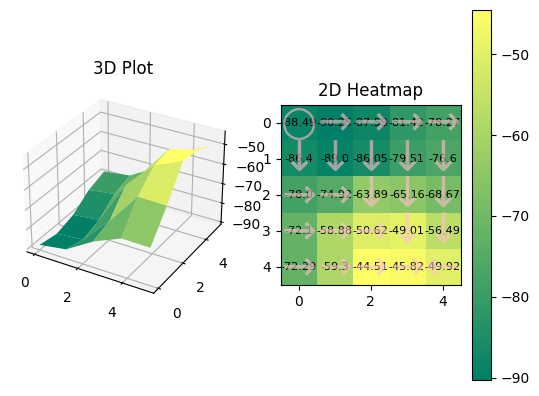

 74%|████████████████████████████████████████████████▊                 | 3697/5000 [00:53<00:12, 106.02it/s]

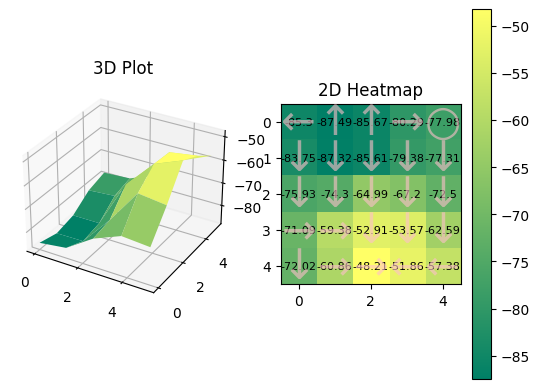

 76%|██████████████████████████████████████████████████                | 3793/5000 [00:55<00:11, 103.52it/s]

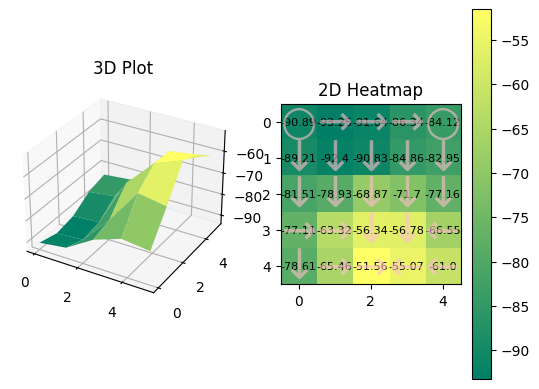

 78%|███████████████████████████████████████████████████▎              | 3889/5000 [00:56<00:10, 103.30it/s]

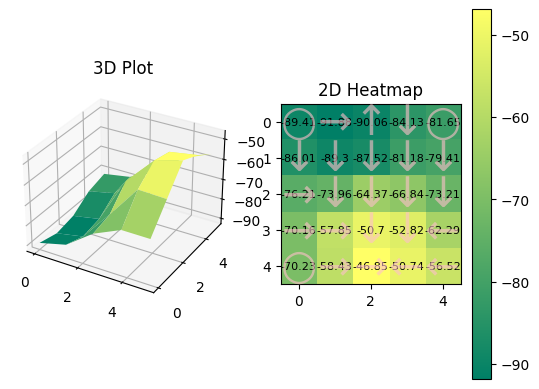

 80%|████████████████████████████████████████████████████▊             | 3997/5000 [00:57<00:09, 104.22it/s]

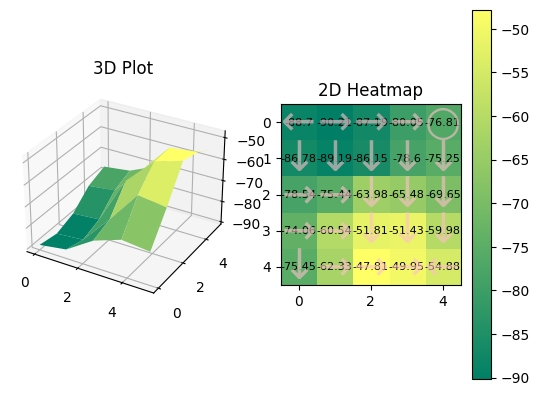

 82%|██████████████████████████████████████████████████████▊            | 4092/5000 [00:59<00:09, 96.18it/s]

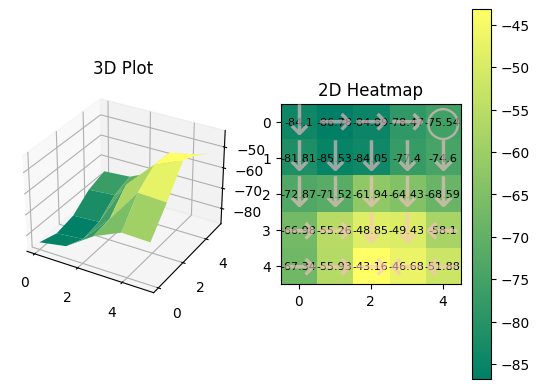

 84%|████████████████████████████████████████████████████████▏          | 4193/5000 [01:00<00:08, 90.15it/s]

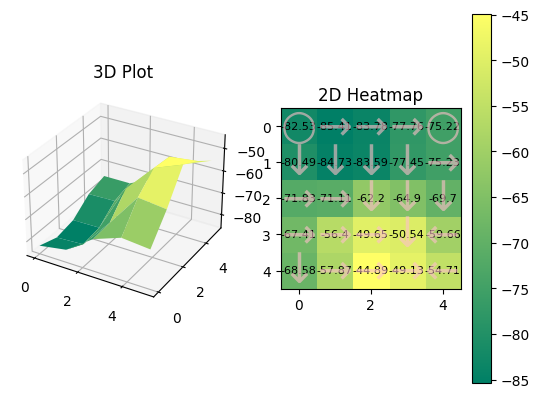

 86%|█████████████████████████████████████████████████████████▌         | 4292/5000 [01:01<00:07, 89.12it/s]

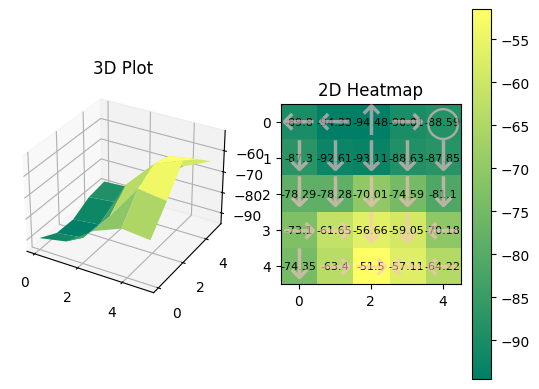

 88%|██████████████████████████████████████████████████████████▊        | 4392/5000 [01:03<00:06, 92.45it/s]

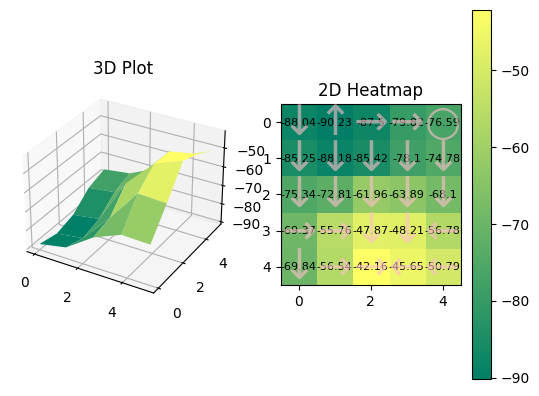

 90%|████████████████████████████████████████████████████████████▏      | 4492/5000 [01:04<00:05, 93.79it/s]

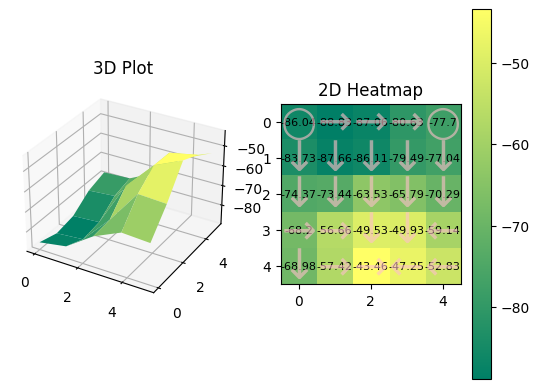

 92%|█████████████████████████████████████████████████████████████▌     | 4592/5000 [01:06<00:04, 92.56it/s]

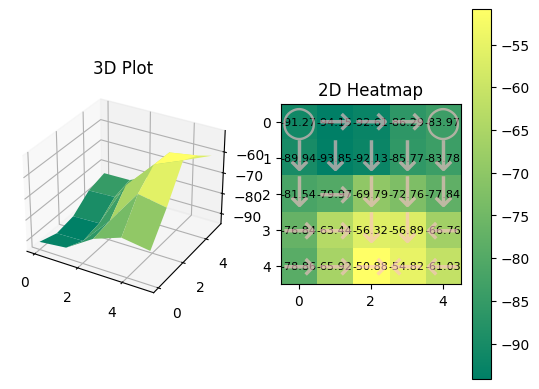

 94%|██████████████████████████████████████████████████████████████▊    | 4692/5000 [01:07<00:03, 93.42it/s]

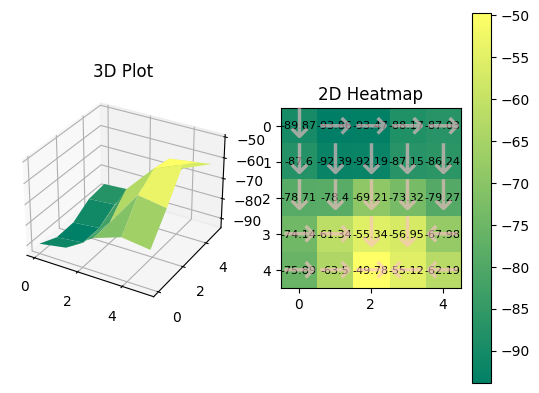

 96%|████████████████████████████████████████████████████████████████▏  | 4792/5000 [01:09<00:02, 93.13it/s]

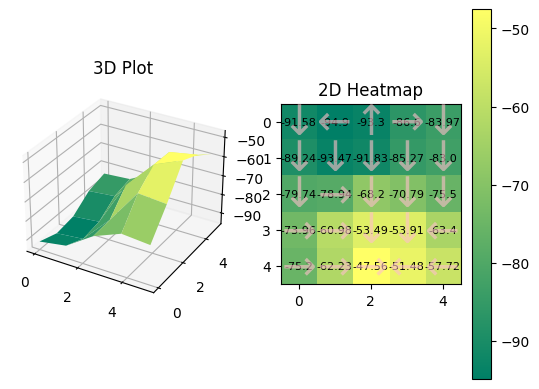

 98%|█████████████████████████████████████████████████████████████████▌ | 4892/5000 [01:10<00:01, 91.79it/s]

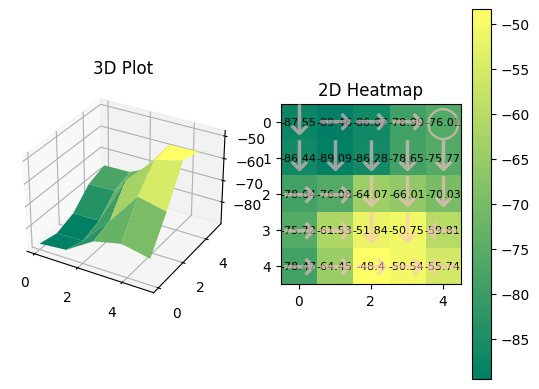

100%|███████████████████████████████████████████████████████████████████| 5000/5000 [01:12<00:00, 69.38it/s]


In [7]:
for _ in tqdm.tqdm(range(5000)):
    
    optimizer.zero_grad()
    
    batch = experiencePool.sample_batch(batch_size=batch_size)
    tmpstate, tmpaction, tmpscore, nextState, nextAction, terminal = batch

    tmpstate = tmpstate.reshape(batch_size,1)
    tmpstate = np.hstack((tmpstate // 5, tmpstate % 5))  #将state变成了行列
    nextState = nextState.reshape(batch_size,1)
    nextState = np.hstack((nextState // 5, nextState % 5))  #将state变成了行列

    tmpstate = torch.tensor(tmpstate,dtype = torch.float32).view(batch_size,2)
    nextState = torch.tensor(nextState,dtype = torch.float32).view(batch_size,2)

    # tmpaction = torch.tensor(tmpaction,dtype = torch.int).view(batch_size,1)
    # nextAction = torch.tensor(nextAction,dtype = torch.int).view(batch_size,1)

    tmpscore = torch.tensor(tmpscore,dtype = torch.float32).view(batch_size,1)
    terminal = torch.tensor(terminal,dtype = torch.float32).view(batch_size,1)

    with torch.no_grad():
        # 以下一个state出发，计算下一个state的五个action values
        next_action_values = network(nextState)  #网络

        
        b = [next_action_values[i,nextAction[i]] for i in range(batch_size)]
        next_action_value = torch.tensor(b,dtype = torch.float32).view(batch_size,1)
        
        # c = next_action_values.max(1)[0] #改成DQN了，这里就得取最大值
        # next_action_value = torch.tensor(c,dtype = torch.float32).view(batch_size,1)
        
        target = tmpscore + (1.0 - terminal) * gamma * next_action_value

    #获得当前的state的五个action values
    now_action_values = network(tmpstate)    #网络
    
    now_action_value = now_action_values[0,tmpaction[0]]
    
    for i in range(1,batch_size):
        now_action_value = torch.cat((now_action_value.view(-1), now_action_values[i,tmpaction[i]].view(-1)),dim=0)
    
    now_action_value = now_action_value.view(-1,1)
    
    loss = F.mse_loss(now_action_value, target)
    loss.backward()
    optimizer.step()
            
    if _ % 100 == 0:
        # s = np.array([[i] for i in range(25)])
        # s = np.hstack((s // 5, s % 5))
        # states = torch.tensor(s, dtype = torch.float32).view(25,2)
        # # 还原成state_values
        # state_values = network(states).view(-1).detach().numpy()
        
        s = np.array([[i] for i in range(25)])
        s = np.hstack((s // 5, s % 5))
        states = torch.tensor(s, dtype = torch.float32).view(25,2)
        # 还原成action_values
        action_values = network(states).view(-1,5).detach().numpy()

        state_values = np.sum(policy * action_values,axis=1)

        
        p = np.argmax(action_values,axis=1)
        draw(state_values.reshape(5,5), p)

In [177]:
action_values

array([[-3.78089249e-02, -1.94776013e-01, -2.53256336e-02,
         1.05417669e-01, -1.58246830e-02],
       [-3.75233740e-02, -1.23834401e-01,  3.99706289e-02,
         1.66287124e-01,  8.22161138e-03],
       [-1.46668572e-02, -1.93817019e-01,  1.18563950e-01,
         1.96197510e-01,  4.14498895e-02],
       [-7.49451108e-03, -2.85866588e-01,  2.12269172e-01,
         2.03578413e-01,  8.67499560e-02],
       [-4.26702015e-03, -3.93100619e-01,  3.23777765e-01,
         1.97639912e-01,  1.33189186e-01],
       [-9.85976160e-02, -1.36740088e-01, -3.12592089e-02,
         4.50991392e-02, -9.55970660e-02],
       [ 7.08011910e-03,  1.37499105e-02,  5.87177500e-02,
         1.30629376e-01, -3.69777977e-02],
       [ 4.21207994e-02, -2.31020935e-02,  1.23867840e-01,
         1.39886275e-01,  5.89378178e-03],
       [ 4.10514399e-02, -1.39208972e-01,  1.93476155e-01,
         1.30437210e-01,  3.31757218e-02],
       [ 3.71916369e-02, -2.64722377e-01,  2.84144908e-01,
         1.29778713e-01